In [1]:
import configuration as config

In [2]:
from collections import deque
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import pickle
import cv2
from google.colab.patches import cv2_imshow
import os

In [3]:
URL_DRIVE = config.URL_DRIVE
IMAGE_PATH = config.IMAGE_PATH
VIDEO_INPUT_PATH = config.VIDEO_INPUT_PATH
plot_path = config.PLOT_PATH

output_path = config.OUTPUT_PATH
video_output_path = config.VIDEO_OUTPUT_PATH


In [4]:
videoname = "video1.mp4"

In [5]:
print("[INFO] Cargando...")
model = load_model(f"{output_path}detector.h5")
lb = pickle.loads(open(f"{output_path}lb.pickle", "rb").read())

[INFO] Cargando...


In [6]:
link = VIDEO_INPUT_PATH + videoname
vs = cv2.VideoCapture(link)
writer = None
(W, H) = (None, None)
grabbed = True
# Loop sobre los frames del video
frame_list = []
shape_list = []
while vs.isOpened():
  (grabbed, frame) = vs.read()
  # Si no coge ningun frame, se sale del bucle
  if not grabbed:
    break

  output = frame.copy()
  frame = cv2.resize(frame, (224,224)).astype("float32")
  frame = frame / 255    
  # Guardamos todos los frames
  frame_list.append(frame)
  shape_list.append(output.shape[:2])

In [7]:
# Se llevan a cabo las operaciones necesarias para poder aplicar el modelo y 
# predecir
frame_list = np.array(frame_list)
boxes = []
labels = []
for i in range(frame_list.shape[0]):
  (boxPreds, labelPreds) = model.predict(np.expand_dims(frame_list[i], axis = 0))
  (startX, startY, endX, endY) = boxPreds[0]
  (h,w) = shape_list[i]
  box = [int(startX * w),int(startY * h),int(endX * w),int(endY * h),]
  boxes.append(box)
  i = np.argmax(labelPreds, axis=1)
  label = lb.classes_[i][0]
  labels.append(label)


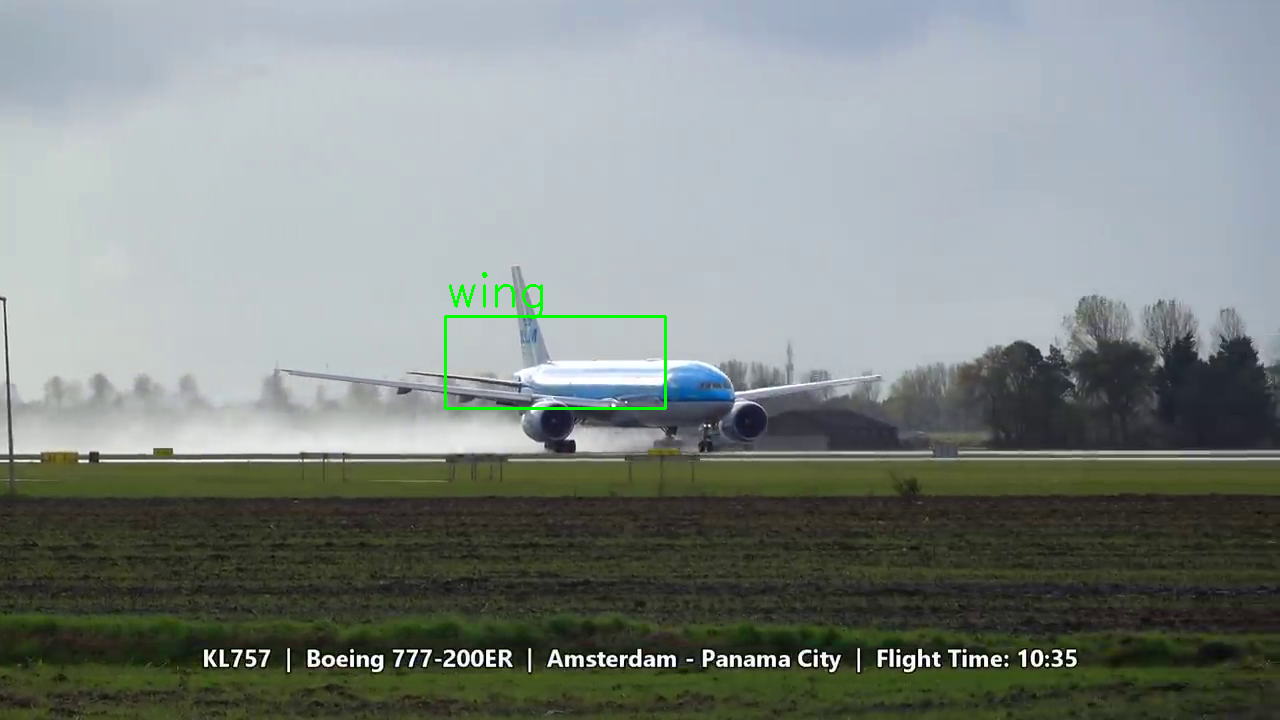

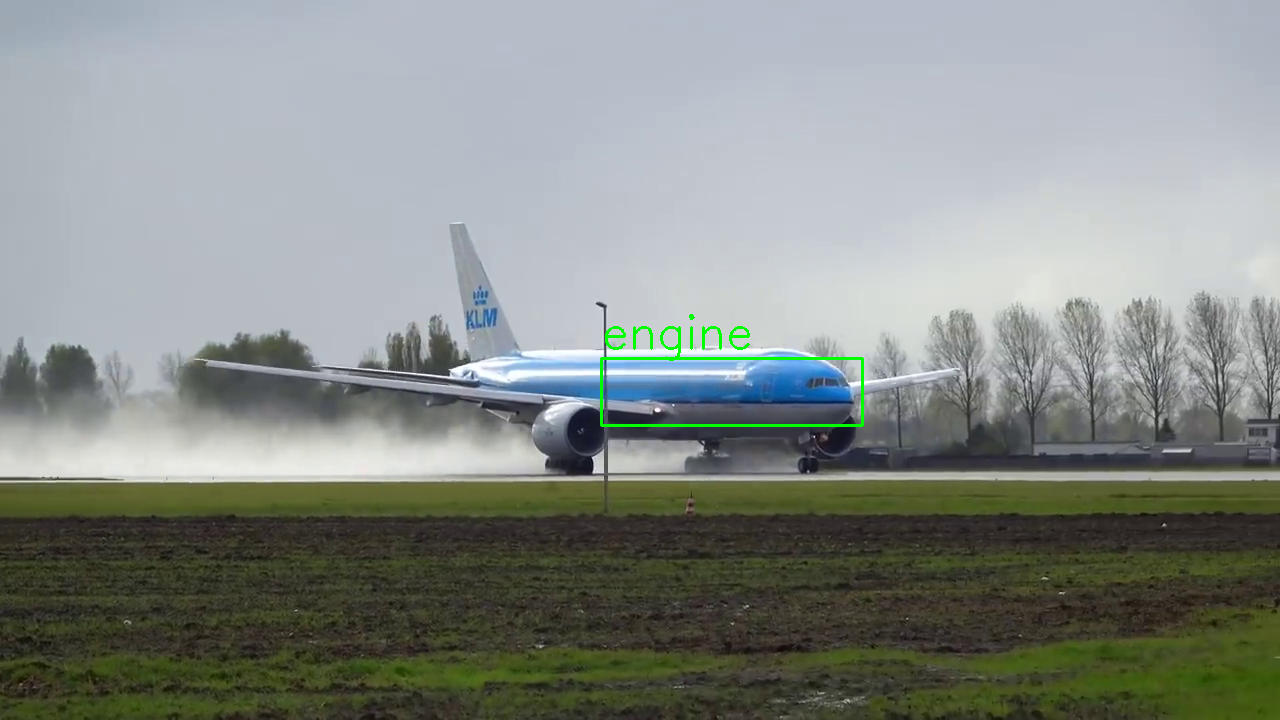

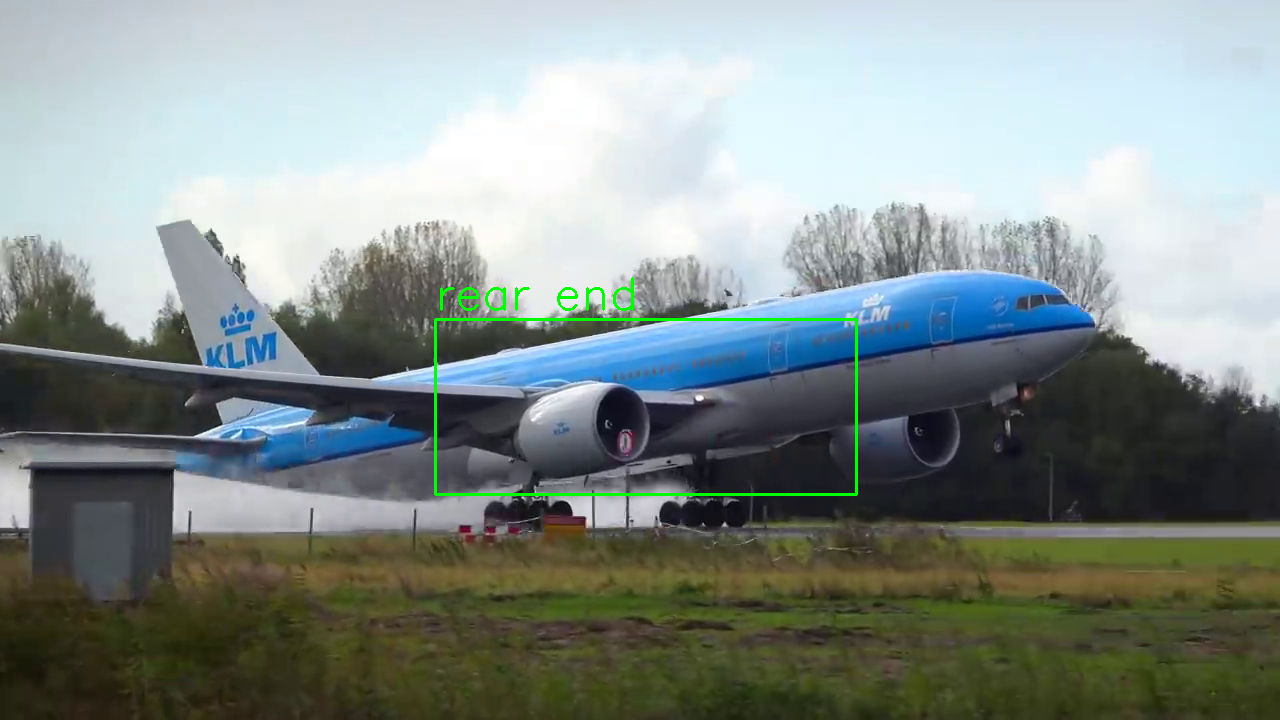

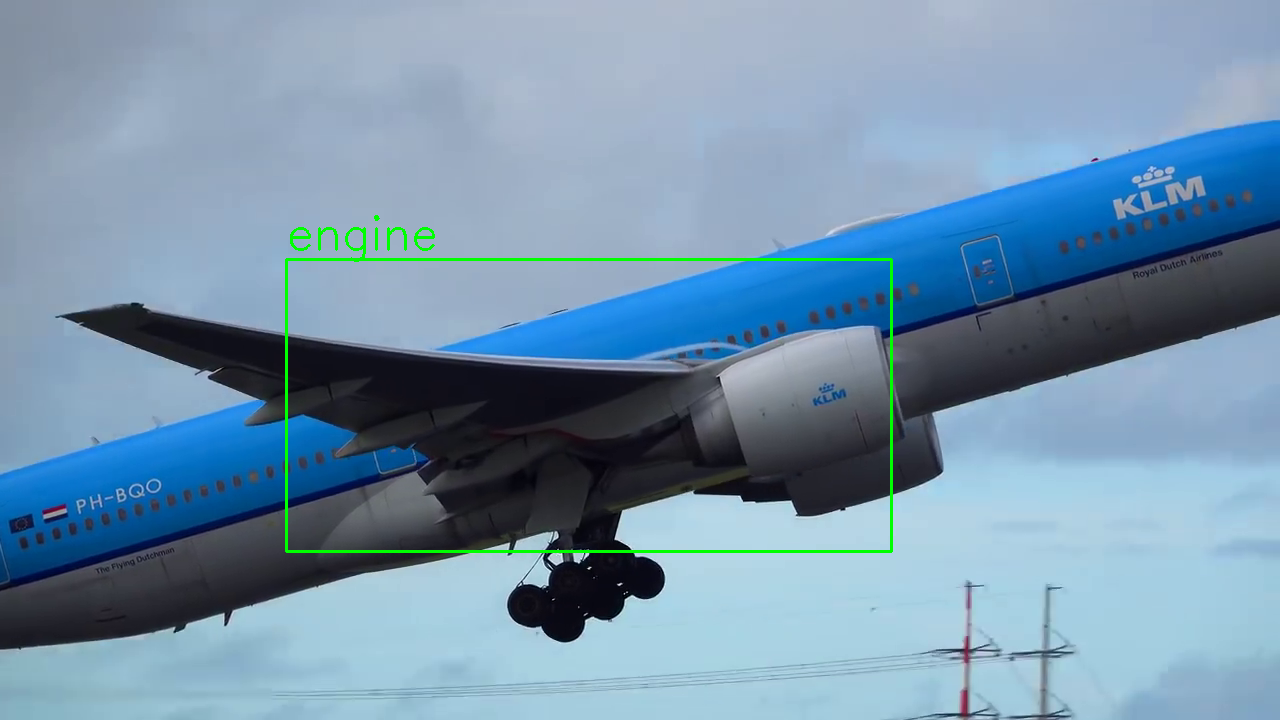

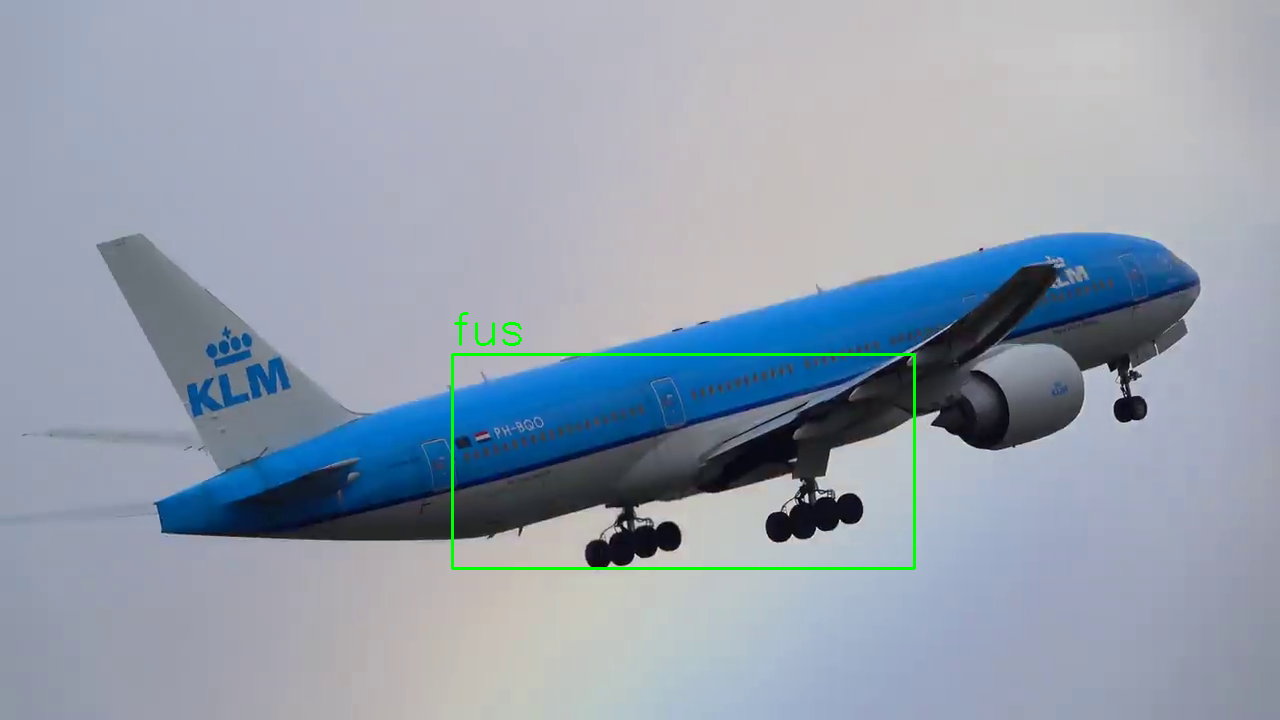

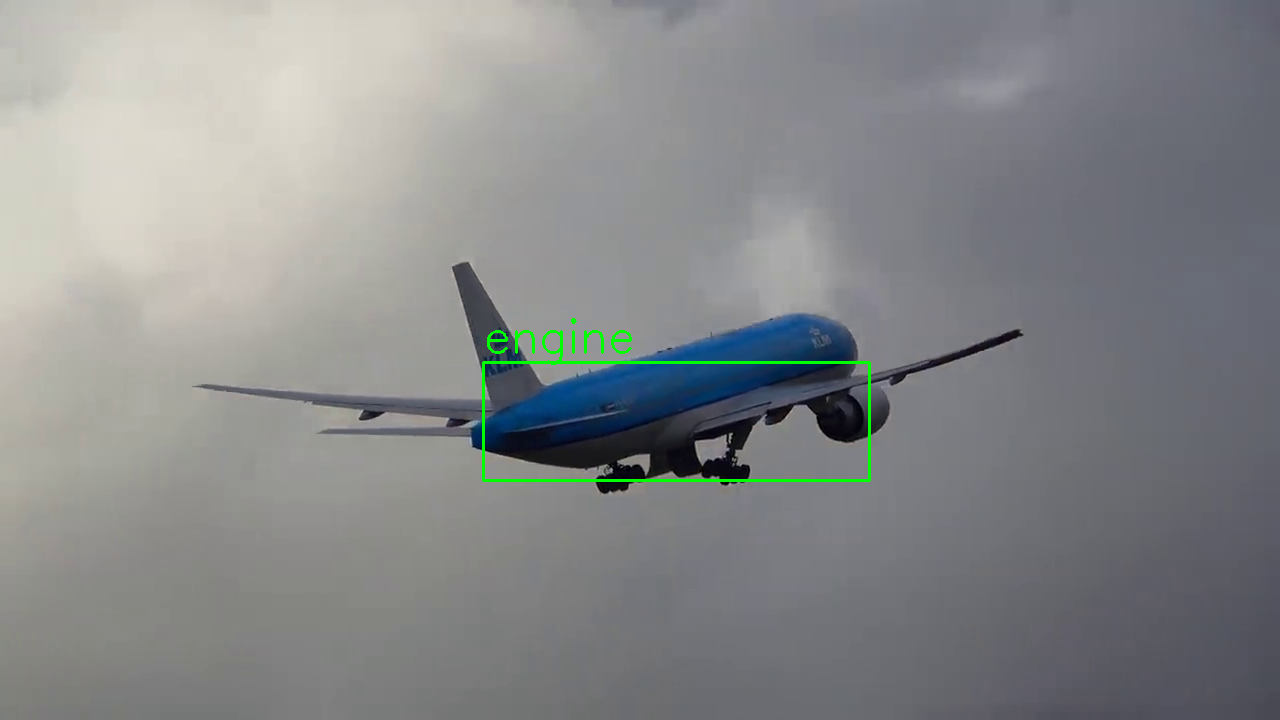

[INFO] Terminando...


In [8]:

vs = cv2.VideoCapture(link)
wirter = None
grabbed = True

j = 0
while grabbed:
  (grabbed, frame) = vs.read()
  if not grabbed:
    break
  output = frame.copy()
  (w,h) = frame.shape[:2]
  startX, startY, endX, endY = boxes[j]
  label = labels[j]
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(output, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
  cv2.rectangle(output, (startX, startY), (endX, endY),(0, 255, 0), 2)
  
  if writer is None:
    # Inicializamos el videowriter
    fourcc = cv2.VideoWriter_fourcc(*'H264') #codec
    writer = cv2.VideoWriter(video_output_path+videoname, fourcc, 30,(w, h), True)
    
    #out = cv2.VideoWriter('output.mp4', fourcc, 20.0, res)
    # write the output frame to disk
  writer.write(frame)
  key = cv2.waitKey(1) & 0xFF
  j = j + 1

  if j in [0,100,200,300,400,500,600]:
     cv2_imshow(output)
  if key == ord("q"):
    break

print("[INFO] Terminando...")
writer.release()
vs.release()